In [ ]:
#new

In [1]:

import os
import zipfile
import shutil
import cv2
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:


zip_file_path = '/content/drive/MyDrive/part_data-imp.zip'
extract_dir = '/content/sample_data/'
os.makedirs(extract_dir, exist_ok=True)

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Files extracted to: {extract_dir}")
except FileNotFoundError:
    print(f"Error: ZIP file not found at {zip_file_path}")
    raise


Files extracted to: /content/sample_data/


In [4]:
import os
import shutil


MAIN_INPUT_FOLDER = "/content/sample_data/archive"
MAIN_OUTPUT_FOLDER = "/content/sample_data/output2"
NON_DEFECTIVE_FOLDER = os.path.join(MAIN_OUTPUT_FOLDER, "non_defective")
DEFECTIVE_FOLDER = os.path.join(MAIN_OUTPUT_FOLDER, "defective")


os.makedirs(NON_DEFECTIVE_FOLDER, exist_ok=True)
os.makedirs(DEFECTIVE_FOLDER, exist_ok=True)


def get_unique_filename(folder, filename):
    base, ext = os.path.splitext(filename)
    counter = 1
    unique_name = filename
    while os.path.exists(os.path.join(folder, unique_name)):
        unique_name = f"{base}_{counter}{ext}"
        counter += 1
    return unique_name


non_defective_count = 0
defective_count = 0


for subfolder in os.listdir(MAIN_INPUT_FOLDER):
    subfolder_path = os.path.join(MAIN_INPUT_FOLDER, subfolder)

    if os.path.isdir(subfolder_path):

        train_good_folder = os.path.join(subfolder_path, "train", "good")
        if os.path.exists(train_good_folder):
            for file in os.listdir(train_good_folder):
                source_path = os.path.join(train_good_folder, file)
                if os.path.isfile(source_path):
                    unique_name = get_unique_filename(NON_DEFECTIVE_FOLDER, file)
                    dest_path = os.path.join(NON_DEFECTIVE_FOLDER, unique_name)
                    shutil.copy(source_path, dest_path)
                    print(f"Copied: {source_path} -> {dest_path}")
                    non_defective_count += 1


        test_good_folder = os.path.join(subfolder_path, "test", "good")
        if os.path.exists(test_good_folder):
            for file in os.listdir(test_good_folder):
                source_path = os.path.join(test_good_folder, file)
                if os.path.isfile(source_path):
                    unique_name = get_unique_filename(NON_DEFECTIVE_FOLDER, file)
                    dest_path = os.path.join(NON_DEFECTIVE_FOLDER, unique_name)
                    shutil.copy(source_path, dest_path)
                    print(f"Copied: {source_path} -> {dest_path}")
                    non_defective_count += 1


        test_folder = os.path.join(subfolder_path, "test")
        if os.path.exists(test_folder):
            for sub_subfolder in os.listdir(test_folder):
                sub_subfolder_path = os.path.join(test_folder, sub_subfolder)

                if sub_subfolder != "good" and os.path.isdir(sub_subfolder_path):
                    for file in os.listdir(sub_subfolder_path):
                        source_path = os.path.join(sub_subfolder_path, file)
                        if os.path.isfile(source_path):
                            unique_name = get_unique_filename(DEFECTIVE_FOLDER, file)
                            dest_path = os.path.join(DEFECTIVE_FOLDER, unique_name)
                            shutil.copy(source_path, dest_path)
                            print(f"Copied: {source_path} -> {dest_path}")
                            defective_count += 1


print(f"Non-defective images copied: {non_defective_count}")
print(f"Defective images copied: {defective_count}")


Streaming output truncated to the last 5000 lines.
Copied: /content/sample_data/archive/carpet/train/good/223.png -> /content/sample_data/output2/non_defective/223.png
Copied: /content/sample_data/archive/carpet/train/good/176.png -> /content/sample_data/output2/non_defective/176_1.png
Copied: /content/sample_data/archive/carpet/train/good/034.png -> /content/sample_data/output2/non_defective/034_1.png
Copied: /content/sample_data/archive/carpet/train/good/227.png -> /content/sample_data/output2/non_defective/227.png
Copied: /content/sample_data/archive/carpet/train/good/264.png -> /content/sample_data/output2/non_defective/264.png
Copied: /content/sample_data/archive/carpet/train/good/181.png -> /content/sample_data/output2/non_defective/181_1.png
Copied: /content/sample_data/archive/carpet/train/good/078.png -> /content/sample_data/output2/non_defective/078_1.png
Copied: /content/sample_data/archive/carpet/train/good/240.png -> /content/sample_data/output2/non_defective/240.png
Copie

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split


MAIN_INPUT_FOLDER = "/content/sample_data/archive"
MAIN_OUTPUT_FOLDER = "/content/sample_data/output2"
NON_DEFECTIVE_FOLDER = os.path.join(MAIN_OUTPUT_FOLDER, "non_defective")
DEFECTIVE_FOLDER = os.path.join(MAIN_OUTPUT_FOLDER, "defective")
TRAIN_DIR = os.path.join(MAIN_OUTPUT_FOLDER, "train")
TEST_DIR = os.path.join(MAIN_OUTPUT_FOLDER, "test")


os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)


train_non_defective = os.path.join(TRAIN_DIR, "non_defective")
train_defective = os.path.join(TRAIN_DIR, "defective")
test_non_defective = os.path.join(TEST_DIR, "non_defective")
test_defective = os.path.join(TEST_DIR, "defective")

os.makedirs(train_non_defective, exist_ok=True)
os.makedirs(train_defective, exist_ok=True)
os.makedirs(test_non_defective, exist_ok=True)
os.makedirs(test_defective, exist_ok=True)


def split_data(src_folder, train_folder, test_folder, test_size=0.2):
    images = [img for img in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, img))]
    train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

    for img in train_images:
        shutil.copy(os.path.join(src_folder, img), train_folder)

    for img in test_images:
        shutil.copy(os.path.join(src_folder, img), test_folder)


split_data(NON_DEFECTIVE_FOLDER, train_non_defective, test_non_defective)

split_data(DEFECTIVE_FOLDER, train_defective, test_defective)

print("Data split into train and test folders!")


Data split into train and test folders!


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


TRAIN_DIR = "/content/sample_data/output2/train"
TEST_DIR = "/content/sample_data/output2/test"


IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50


train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 4282 images belonging to 2 classes.
Found 1072 images belonging to 2 classes.


In [7]:


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))


for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)


history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=test_data,
    callbacks=[early_stopping, checkpoint]
)

print("Training Complete!")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


134/134 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.7345 - loss: 0.6035 - val_accuracy: 0.7649 - val_loss: 0.5658
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.7521 - loss: 0.5860 - val_accuracy: 0.7649 - val_loss: 0.5468
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.7633 - loss: 0.5663 - val_accuracy: 0.7649 - val_loss: 0.5800
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.7525 - loss: 0.5779 - val_accuracy: 0.7649 - val_loss: 0.5551
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.7594 - loss: 0.5586 - val_accuracy: 0.7649 - val_loss: 0.5742
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.7618 - loss: 0.5607 - val_accuracy: 0.7649 - val_loss: 0.5499
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.7717 - loss: 0.5449 - val_accuracy: 0.7649 - val_loss: 0.5493
Training Complete!


In [8]:

model.save('classification_model.h5')


In [9]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score


y_pred_probs = model.predict(test_data)
y_pred = (y_pred_probs > 0.5).astype(int)


y_true = test_data.classes


cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)


report = classification_report(y_true, y_pred, target_names=['Non-Defective', 'Defective'])
print("Classification Report:")
print(report)


precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


auc = roc_auc_score(y_true, y_pred_probs)
print(f"ROC-AUC Score: {auc:.2f}")


34/34 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step
Confusion Matrix:
[[  0 252]
 [  0 820]]
Classification Report:
               precision    recall  f1-score   support

Non-Defective       0.00      0.00      0.00       252
    Defective       0.76      1.00      0.87       820

     accuracy                           0.76      1072
    macro avg       0.38      0.50      0.43      1072
 weighted avg       0.59      0.76      0.66      1072

Precision: 0.76
Recall: 1.00
F1-Score: 0.87
ROC-AUC Score: 0.56


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:

test_loss, test_accuracy = model.evaluate(test_data, verbose=1)


print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


34/34 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.4500 - loss: 0.9606
Test Accuracy: 76.49%


34/34 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step


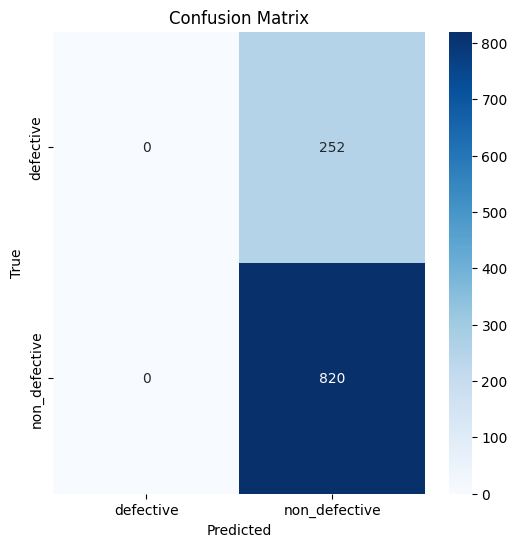

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


predictions = (model.predict(test_data) > 0.5).astype("int32")


true_labels = test_data.classes


cm = confusion_matrix(true_labels, predictions)


plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


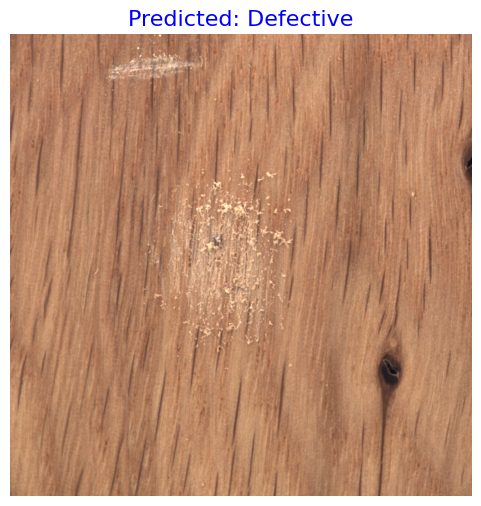

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array


IMG_SIZE = (224, 224)


def classify_and_display_image(image_path, model, class_indices):
    """
    Classify an image as defective or non-defective and display it.

    Parameters:
    - image_path: Path to the input image.
    - model: The trained model.
    - class_indices: A dictionary mapping class names to indices.

    Returns:
    - None
    """

    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)


    prediction = model.predict(img_array)


    class_name = "Non-Defective" if prediction < 0.5 else "Defective"


    plt.figure(figsize=(6, 6))
    plt.imshow(load_img(image_path))
    plt.axis("off")
    plt.title(f"Predicted: {class_name}", fontsize=16, color="blue")
    plt.show()


image_path = "/content/sample_data/output2/defective/000_44.png"


classify_and_display_image(image_path, model, test_data.class_indices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


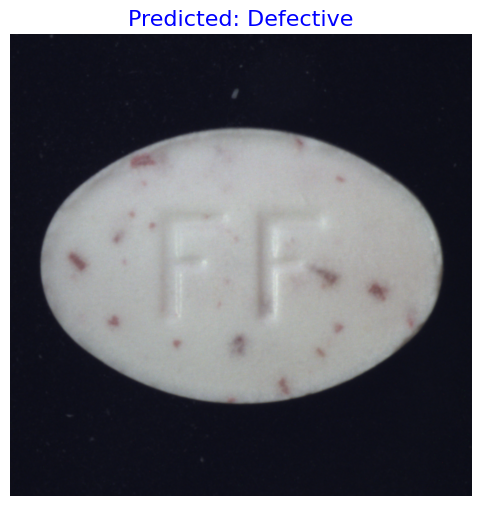

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array


IMG_SIZE = (224, 224)


def classify_and_display_image(image_path, model, class_indices):
    """
    Classify an image as defective or non-defective and display it.

    Parameters:
    - image_path: Path to the input image.
    - model: The trained model.
    - class_indices: A dictionary mapping class names to indices.

    Returns:
    - None
    """

    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)


    prediction = model.predict(img_array)


    class_name = "Non-Defective" if prediction < 0.5 else "Defective"


    plt.figure(figsize=(6, 6))
    plt.imshow(load_img(image_path))
    plt.axis("off")
    plt.title(f"Predicted: {class_name}", fontsize=16, color="blue")
    plt.show()


image_path = "/content/sample_data/output2/non_defective/009_24.png"


classify_and_display_image(image_path, model, test_data.class_indices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


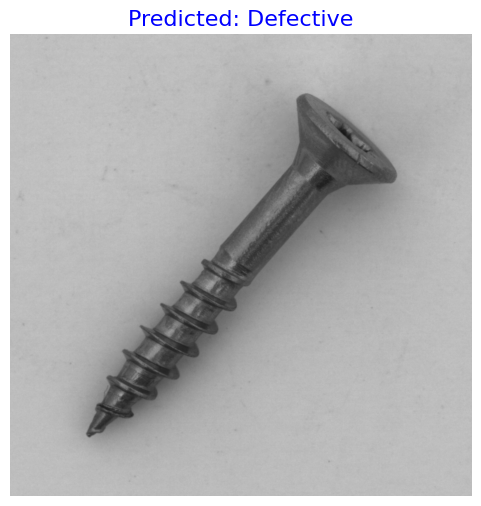

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array


IMG_SIZE = (224, 224)


def classify_and_display_image(image_path, model, class_indices):
    """
    Classify an image as defective or non-defective and display it.

    Parameters:
    - image_path: Path to the input image.
    - model: The trained model.
    - class_indices: A dictionary mapping class names to indices.

    Returns:
    - None
    """

    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)


    prediction = model.predict(img_array)


    class_name = "Non-Defective" if prediction < 0.5 else "Defective"


    plt.figure(figsize=(6, 6))
    plt.imshow(load_img(image_path))
    plt.axis("off")
    plt.title(f"Predicted: {class_name}", fontsize=16, color="blue")
    plt.show()


image_path = "/content/sample_data/output2/non_defective/038_17.png"


classify_and_display_image(image_path, model, test_data.class_indices)
